In [151]:
import numpy as np
import pandas as pd
import os
import json
import torch
from torchvision import models
from torch import nn
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import copy
from tqdm import tqdm 
import timm


In [145]:
ROOT = 'Datasets'
TRAIN_IMAGES_PATH = os.path.join(ROOT, 'train_images')

# Load the CSV file
train_df = pd.read_csv(os.path.join(ROOT, 'train.csv'))

# Create image paths
train_df['path'] = TRAIN_IMAGES_PATH + '/' + train_df['image_id']
train_df.head(10)

,image_id,label,path
0,1000015157.jpg,0,Datasets\train_images/1000015157.jpg
1,1000201771.jpg,3,Datasets\train_images/1000201771.jpg
2,100042118.jpg,1,Datasets\train_images/100042118.jpg
3,1000723321.jpg,1,Datasets\train_images/1000723321.jpg
4,1000812911.jpg,3,Datasets\train_images/1000812911.jpg
5,1000837476.jpg,3,Datasets\train_images/1000837476.jpg
6,1000910826.jpg,2,Datasets\train_images/1000910826.jpg
7,1001320321.jpg,0,Datasets\train_images/1001320321.jpg
8,1001723730.jpg,4,Datasets\train_images/1001723730.jpg
9,1001742395.jpg,3,Datasets\train_images/1001742395.jpg


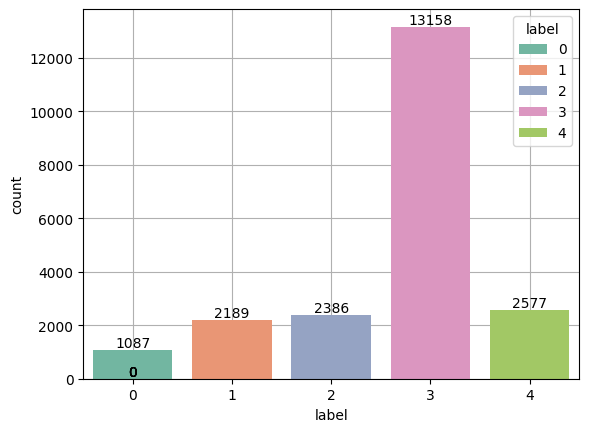

In [146]:
ax = sns.countplot(train_df , x = 'label', hue= "label",palette = "Set2")
# Loop through each bar in the countplot
for p in ax.patches:
    # Get the height of the bar (which represents the count)
    height = p.get_height()
    # Place a text above each bar
    # The first argument of `ax.text()` is the x position, which is the center of the bar
    # The second argument is the y position, which we set slightly above the bar
    # The third argument is the text we want to display, which is the height of the bar converted to string
    ax.text(p.get_x() + p.get_width() / 2., height + 100, int(height), ha='center')

ax.set_axisbelow(True)
plt.grid()
plt.show()

In [147]:
with open(ROOT + "/label_num_to_disease_map.json", "r") as f:
    print(json.dumps(json.loads(f.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [155]:
def show_leaf_disease_pre(label):
    sample = train_df[train_df.label == label].sample(6)
    plt.figure(figsize=(10,10))
    for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(TRAIN_IMAGES_PATH, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

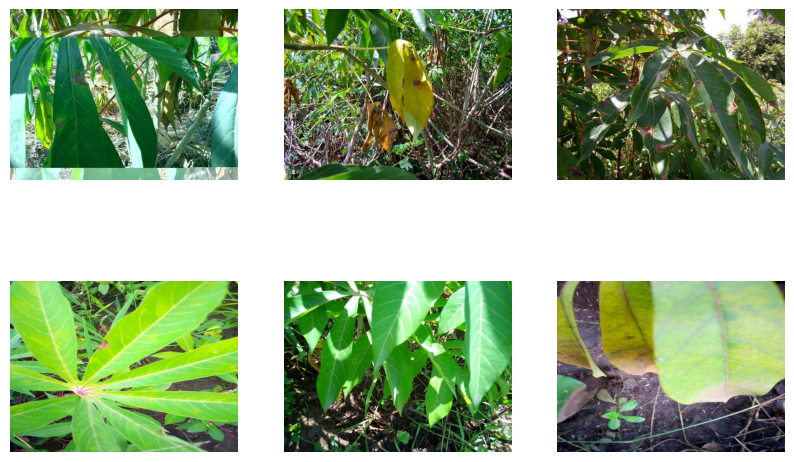

In [156]:
#Cassava Bacterial Blight (CBB)
show_leaf_disease_pre(0)

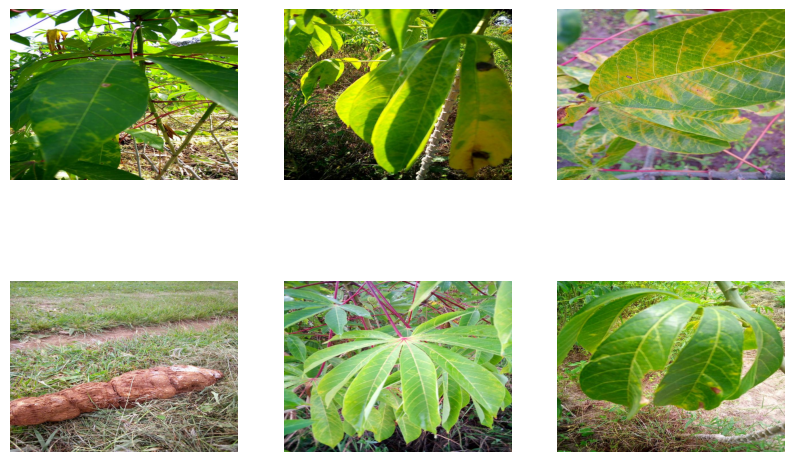

In [118]:
#Cassava Brown Streak Disease (CBSD)
show_leaf_disease_pre(1)

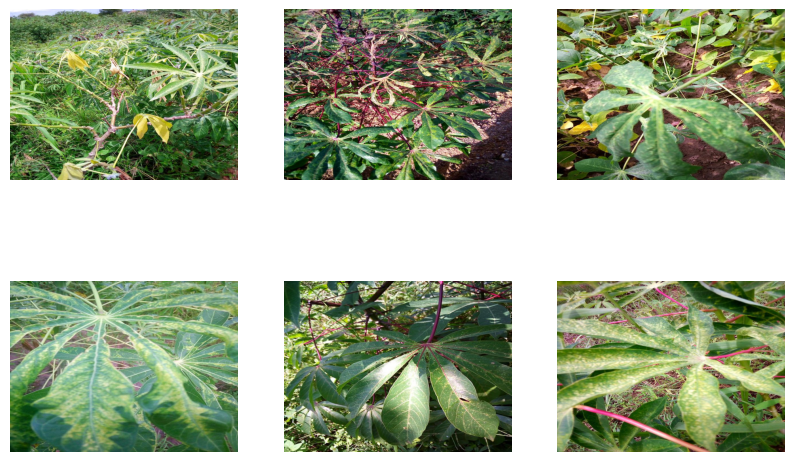

In [119]:
#Cassava Green Mottle (CGM)
show_leaf_disease_pre(2)

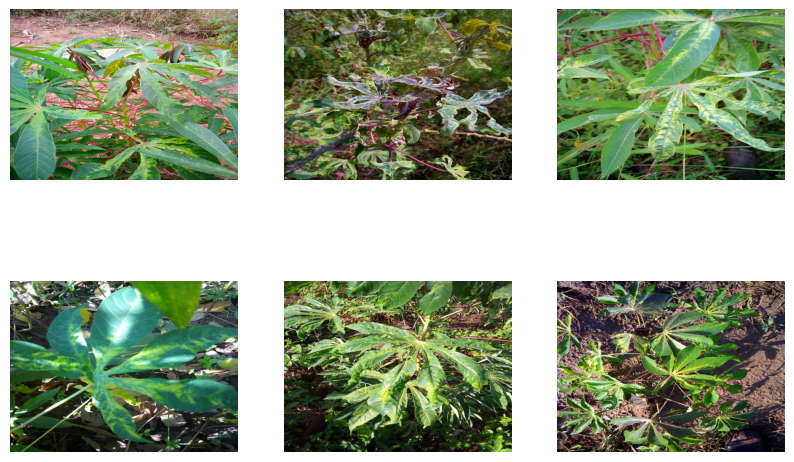

In [120]:
#Cassava Mosaic Disease (CMD)
show_leaf_disease_pre(3)

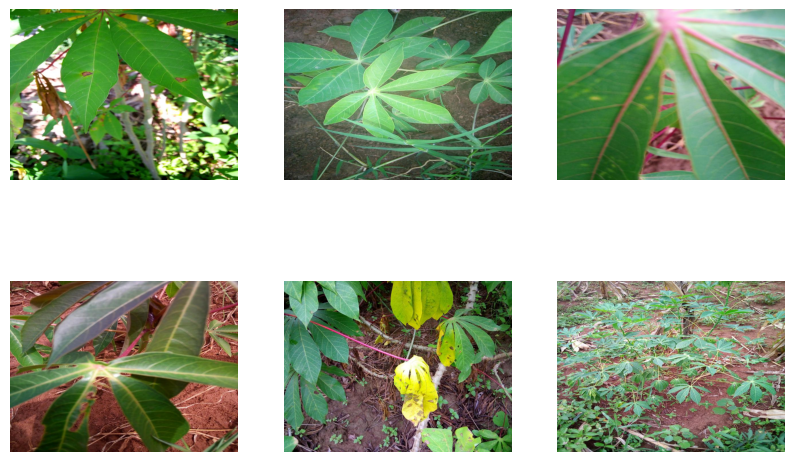

In [121]:
#healthy leaf
show_leaf_disease_pre(4)

In [67]:
class CassavaDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)  # Reset the index
        #self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #print("index is " , index)
        if index >= len(self.df):
            raise IndexError('Index out of range')
        img = Image.open(self.df['path'][index])
        img = np.array(img)
        label = torch.tensor(self.df['label'][index], dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


In [68]:
train_dataset = CassavaDataset(train_df)

# Count the number of non-existent files
train_df['is_exists'] = train_df['path'].apply(lambda x: os.path.exists(x))
n_not_exists = train_df[train_df['is_exists'] == False].shape[0]

# Raise an assertion error if there are non-existent files
assert n_not_exists == 0, f'There are {n_not_exists} non-existent files'

# Count the number of images (existent files)
n_images = train_df[train_df['is_exists'] == True].shape[0]
print(f'Total images: {n_images}')

# Display the first 20 rows of the DataFrame
train_df.head(10)

Total images: 21397


,image_id,label,path,is_exists
0,1000015157.jpg,0,train_images/1000015157.jpg,True
1,1000201771.jpg,3,train_images/1000201771.jpg,True
2,100042118.jpg,1,train_images/100042118.jpg,True
3,1000723321.jpg,1,train_images/1000723321.jpg,True
4,1000812911.jpg,3,train_images/1000812911.jpg,True
5,1000837476.jpg,3,train_images/1000837476.jpg,True
6,1000910826.jpg,2,train_images/1000910826.jpg,True
7,1001320321.jpg,0,train_images/1001320321.jpg,True
8,1001723730.jpg,4,train_images/1001723730.jpg,True
9,1001742395.jpg,3,train_images/1001742395.jpg,True


In [69]:
transform =  transforms.ToTensor()

n_images = len(train_df)
n_train = int(n_images * 0.6)  # 60% of the dataset
n_val = int(n_images * 0.2)  # 20% of the dataset
n_test = n_images - n_train - n_val  # The remaining 20%

train_df = CassavaDataset(train_df, transform=transform)
train_df, val_df, test_df = random_split(
    train_df, 
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)  # Seed for reproducibility
)

print('Splitted dataset:')
print(f'\t- Training set: {len(train_df)}')
print(f'\t- Validation set: {len(val_df)}')
print(f'\t- Testing set: {len(test_df)}')

Splitted dataset:
	- Training set: 12838
	- Validation set: 4279
	- Testing set: 4280


In [70]:
WIDTH = 512
HEIGHT = 512
NUM_CLASSES = 5
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {DEVICE}')

Device: cuda


In [71]:
train_dl = DataLoader(train_df, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_df, BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_df, BATCH_SIZE, shuffle=True)

In [72]:
n_train = len(train_dl)
n_val = len(val_dl)
n_test = len(test_dl)

print('Splitted dataset:')
print(f'\t- Training set: {n_train}')
print(f'\t- Validation set: {n_val}')
print(f'\t- Testing set: {n_test}')

Splitted dataset:
	- Training set: 201
	- Validation set: 67
	- Testing set: 67


In [74]:
def get_model():
    
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    for params in model.parameters():
        params.requires_grad = False
        
    in_feat = model.fc.in_features
        
    model.fc = nn.Sequential(
          nn.Linear(in_feat, 256),
          nn.ReLU(),
          nn.Dropout(p=0.3),
          nn.Linear(256, NUM_CLASSES))
    
    model = model.to(DEVICE)
    
    return model

In [75]:
model = get_model()

summary(model, input_size=(BATCH_SIZE, 3, WIDTH, HEIGHT))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 5]                   --
├─Conv2d: 1-1                            [64, 64, 256, 256]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 256, 256]        (128)
├─ReLU: 1-3                              [64, 64, 256, 256]        --
├─MaxPool2d: 1-4                         [64, 64, 128, 128]        --
├─Sequential: 1-5                        [64, 64, 128, 128]        --
│    └─BasicBlock: 2-1                   [64, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [64, 64, 128, 128]        (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 128, 128]        (128)
│    │    └─ReLU: 3-3                    [64, 64, 128, 128]        --
│    │    └─Conv2d: 3-4                  [64, 64, 128, 128]        (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 128, 128]        (128)
│    │    └─ReLU: 3-6                    [64, 64, 128, 128]

In [133]:
num_epochs = 10
patience = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)

In [134]:
import copy
from tqdm import tqdm 

def train(model, num_epochs, train_dl, valid_dl):
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_valid_loss = np.inf
    
    for epoch in range(num_epochs):
        
        model.train()
        
        batch_num = 0
        
        for x_batch, y_batch in tqdm(train_dl,desc=f'Epoch {epoch+1}/{num_epochs}'):
            
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            batch_num += 1
            #if (batch_num % 100 == 0):
                #print(f'Batch number: {batch_num}')
            
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().item()
        
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        scheduler.step()
        
        model.eval()
        
        with torch.no_grad():
            
            for x_batch, y_batch in valid_dl:
                
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().item()
                
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        if accuracy_hist_valid[epoch] > best_acc:
            best_acc = accuracy_hist_valid[epoch]
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f'Epoch {epoch+1}:   Train accuracy: {accuracy_hist_train[epoch]:.4f}    Validation accuracy: {accuracy_hist_valid[epoch]:.4f} ')
    
    
        if loss_hist_valid[epoch] < min_valid_loss:
            counter = 0
        else:
            counter += 1
    
        if counter >= patience:
            break
    
    
    model.load_state_dict(best_model_wts)
    
    history = {}
    history['loss_hist_train'] = loss_hist_train
    history['loss_hist_valid'] = loss_hist_valid
    history['accuracy_hist_train'] = accuracy_hist_train
    history['accuracy_hist_valid'] = accuracy_hist_valid
    
    return model, history

In [135]:
best_model, hist = train(model, num_epochs, train_dl, val_dl)










































































































































































































Epoch 1/10: 100%|██████████| 201/201 [03:39<00:00,  1.09s/it]


Epoch 1:   Train accuracy: 0.5913    Validation accuracy: 0.6819 












































































































































































































Epoch 2/10: 100%|██████████| 201/201 [03:41<00:00,  1.10s/it]


Epoch 2:   Train accuracy: 0.6702    Validation accuracy: 0.7392 












































































































































































































Epoch 3/10: 100%|██████████| 201/201 [03:43<00:00,  1.11s/it]


Epoch 3:   Train accuracy: 0.7023    Validation accuracy: 0.7572 












































































































































































































Epoch 4/10: 100%|██████████| 201/201 [03:40<00:00,  1.10s/it]


Epoch 4:   Train accuracy: 0.7278    Validation accuracy: 0.7738 












































































































































































































Epoch 5/10: 100%|██████████| 201/201 [03:45<00:00,  1.12s/it]


Epoch 5:   Train accuracy: 0.7405    Validation accuracy: 0.7855 












































































































































































































Epoch 6/10: 100%|██████████| 201/201 [03:36<00:00,  1.08s/it]


Epoch 6:   Train accuracy: 0.7525    Validation accuracy: 0.7808 












































































































































































































Epoch 7/10: 100%|██████████| 201/201 [03:31<00:00,  1.05s/it]


Epoch 7:   Train accuracy: 0.7582    Validation accuracy: 0.7820 












































































































































































































Epoch 8/10: 100%|██████████| 201/201 [03:22<00:00,  1.01s/it]


Epoch 8:   Train accuracy: 0.7649    Validation accuracy: 0.7885 












































































































































































































Epoch 9/10: 100%|██████████| 201/201 [03:17<00:00,  1.02it/s]


Epoch 9:   Train accuracy: 0.7630    Validation accuracy: 0.7864 












































































































































































































Epoch 10/10: 100%|██████████| 201/201 [03:19<00:00,  1.01it/s]


Epoch 10:   Train accuracy: 0.7724    Validation accuracy: 0.7894 


In [136]:
label_list = []
prediction_list = []

with torch.no_grad():
    for image, label in tqdm(test_dl):
        
        image = image.to(DEVICE)
        logits = best_model(image)
        probs = torch.nn.functional.softmax(logits, dim=1).detach().cpu().numpy()
        prediction = np.argmax(probs, axis=1)
        label_list += label.numpy().tolist()
        prediction_list += prediction.tolist()





































































100%|██████████| 67/67 [01:14<00:00,  1.11s/it]


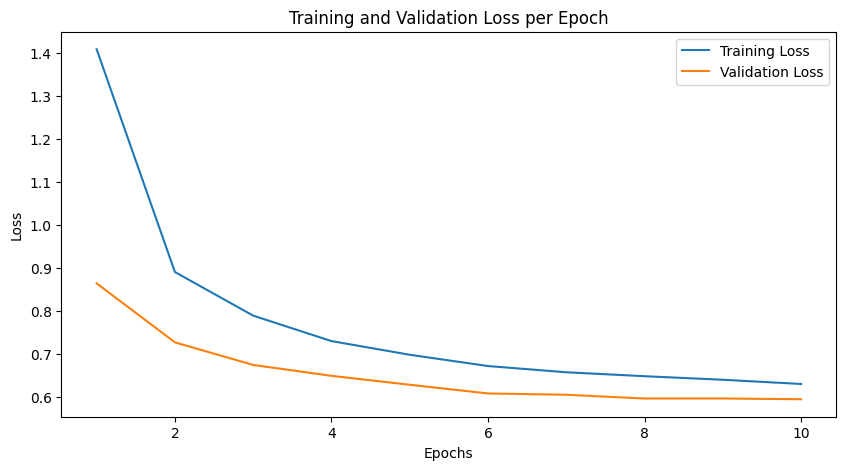

In [143]:
import matplotlib.pyplot as plt

# Assuming 'history' is a dictionary that contains loss values for training and validation
# And also assuming that the number of epochs is contained in the length of the loss lists

epochs = list(range(1, len(hist['loss_hist_train']) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, hist['loss_hist_train'], label='Training Loss')
plt.plot(epochs, hist['loss_hist_valid'], label='Validation Loss')

plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [139]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(label_list, prediction_list))


              precision    recall  f1-score   support

           0       0.48      0.32      0.39       188
           1       0.58      0.46      0.51       417
           2       0.71      0.52      0.60       490
           3       0.86      0.94      0.90      2681
           4       0.56      0.57      0.56       504

    accuracy                           0.78      4280
   macro avg       0.64      0.56      0.59      4280
weighted avg       0.76      0.78      0.77      4280



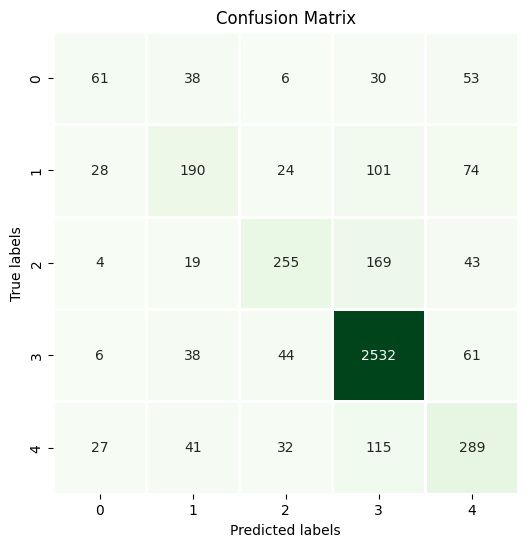

In [140]:
cm = confusion_matrix(label_list, prediction_list)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, linewidth=1, linecolor='white')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()